# BA Load Map Video

This notebook plots the evolution of hourly electricity demand by BA.


In [80]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from datetime import timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [4]:
# Identify the data input and output directories:
ba_load_dir =  '/Users/burl878/Documents/Code/code_repos/heat_wave_load_visualization/data/tell_output/'
metadata_dir =  '/Users/burl878/Documents/Code/code_repos/heat_wave_load_visualization/data/metadata/'
output_dir = '/Users/burl878/Documents/Code/code_repos/heat_wave_load_visualization/data/'
image_output_dir = '/Users/burl878/Documents/Code/code_repos/heat_wave_load_visualization/plots/'


## Process the WECC Total Load Time Series


In [57]:
# Define a function to process total load time series for the WECC:
def process_wecc_load_time_series(ba_load_dir: str, metadata_dir: str):
    
    # Read in the BA-to-Interconnection mapping file:
    ba_df = pd.read_csv((metadata_dir + 'BA_to_Interconnection_Mapping.csv'))
 
    # Read in the TELL output file for 2018:
    tell_df = pd.read_csv((ba_load_dir + 'historic/2018/TELL_Balancing_Authority_Hourly_Load_Data_2018_Scaled_2018.csv'))
   
    # Merge the mapping and load dataframes together:
    tell_df = tell_df.merge(ba_df, on=['BA_Code'])
    
    # Subset to just the BAs in the WECC:
    tell_df = tell_df.loc[tell_df['Interconnection'] == 'WECC']
    
    # Rename a few columns to make them more readable:
    tell_df.rename(columns={'BA_Code': 'BA', 'BA_Number': 'ID', 'Scaled_TELL_BA_Load_MWh': 'BA_Load_MWh'}, inplace=True)

    # Sum the WECC total loads as a function of time:
    tell_df['WECC_Load_MWh'] = tell_df.groupby('Time_UTC')['BA_Load_MWh'].transform('sum')
    
    # Pull out the WECC loads into a separate dataframe:
    wecc_df = tell_df[['Time_UTC', 'WECC_Load_MWh']].copy().drop_duplicates()
    
    # Subset to just the columns we need:
    tell_df = tell_df[['BA', 'ID', 'Time_UTC', 'BA_Load_MWh']].copy()
    
    # Output the cleaned dataframes:
    return tell_df, wecc_df


In [58]:
tell_df, wecc_df = process_wecc_load_time_series(ba_load_dir = ba_load_dir, 
                                                 metadata_dir = metadata_dir)

tell_df


,BA,ID,Time_UTC,BA_Load_MWh
17520,AVA,20169.0,2018-01-01 00:00:00,1832.61
17521,AVA,20169.0,2018-01-01 01:00:00,1908.90
17522,AVA,20169.0,2018-01-01 02:00:00,1973.37
17523,AVA,20169.0,2018-01-01 03:00:00,2022.46
17524,AVA,20169.0,2018-01-01 04:00:00,1990.14
...,...,...,...,...
473035,WAUW,19610.0,2018-12-31 19:00:00,113.09
473036,WAUW,19610.0,2018-12-31 20:00:00,112.31
473037,WAUW,19610.0,2018-12-31 21:00:00,111.33
473038,WAUW,19610.0,2018-12-31 22:00:00,110.22


In [184]:
# Define a function to plot the animation of BA and WECC loads over a given date range:
def plot_ba_load_map(start_date: str, end_date: str, ba_load_dir: str, metadata_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the BA and states shapefile:
    ba_shapes_df = gpd.read_file((metadata_dir + 'wecc_shapefiles/west_ba_voronoi_shp/west_ba_voronoi_shp.shp'))
    states_df = gpd.read_file((metadata_dir + 'wecc_shapefiles/wecc_state_border_shp/wecc_state_border_shp.shp'))
    
    # Process the loads using the function defined above:
    tell_df, wecc_df = process_wecc_load_time_series(ba_load_dir = ba_load_dir, 
                                                 metadata_dir = metadata_dir)
    
    # Subset the two dataframes to just the period of interest:
    tell_df = tell_df.loc[(tell_df['Time_UTC'] >= start_date) & (tell_df['Time_UTC'] <= end_date)]
    wecc_df = wecc_df.loc[(wecc_df['Time_UTC'] >= start_date) & (wecc_df['Time_UTC'] <= end_date)]
    
    # Calculate the maximum load to use:
    max_ba_load = tell_df['BA_Load_MWh'].max()
    max_wecc_load = 1.02*wecc_df['WECC_Load_MWh'].max()
    min_wecc_load = 0.98*wecc_df['WECC_Load_MWh'].min()
    
    # Set the 'Time_UTC' value as a datetime variable:
    wecc_df['Time_UTC'] = pd.to_datetime(wecc_df['Time_UTC'])
    
    # Create a list of all of the times in the date range:
    times = tell_df['Time_UTC'].unique()
    
    # Set the colormap:
    colors = plt.get_cmap('YlGnBu', 45)
    
    # Loop over the list of BAs in the interconnection:
    # for i in range(len(ba_list)):
    for i in range(1):
        i = 100
        
        # Subset the BA loads dataframe to just that time:
        tell_hour_df = tell_df.loc[(tell_df['Time_UTC'] == times[i])]
    
        # Merge the load dataframe into the shapefiles dataframe using BA ID # to merge:
        bas_df = ba_shapes_df.merge(tell_hour_df, on='ID', how='left')
    
        # Plot the map of BA loads:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,13))
        ax1 = bas_df.plot(ax=axes[0], column='BA_Load_MWh', cmap=colors, vmin=0, vmax=max_ba_load, edgecolor='grey', linewidth=0.0, legend=True, 
                          legend_kwds={'label': 'Balancing Authority Load [MWh]', 'orientation': 'horizontal'})
        ax1 = states_df.plot(ax=axes[0], edgecolor='black', linewidth=1)
        ax1.set_title(('Balancing Authority Loads: ' + times[i]))
        axes[0].set_ylabel('Latitude [$^\circ$N]')
        axes[0].set_xlabel('Longitude [$^\circ$W]')
        
        # Plot the time-series of WECC total loads:
        axes[1].plot(wecc_df['Time_UTC'], wecc_df['WECC_Load_MWh'], 'r-', linewidth=2)
        axes[1].plot([pd.to_datetime(times[i]), times[i]], [min_wecc_load, max_wecc_load], 'k-', linewidth=2)
        axes[1].set_xlabel('Time [UTC]')
        axes[1].set_ylabel('WECC Total Hourly Load [MWh]')
        axes[1].set_xlim([pd.to_datetime(start_date), pd.to_datetime(end_date)])
        axes[1].set_ylim([min_wecc_load, max_wecc_load])
        axes[1].set_title(('WECC Total Load: ' + times[i]))

        time_string = times[i].replace(" ", "_").replace(":", "_").replace("-", "_")
                
        # If the "save_images" flag is set to true then save the plot to a .png file:
        if save_images == True:
           plt.savefig(os.path.join(image_output_dir, ('Loads_' + time_string + '.png')), 
                       dpi=image_resolution, bbox_inches='tight', facecolor='white')


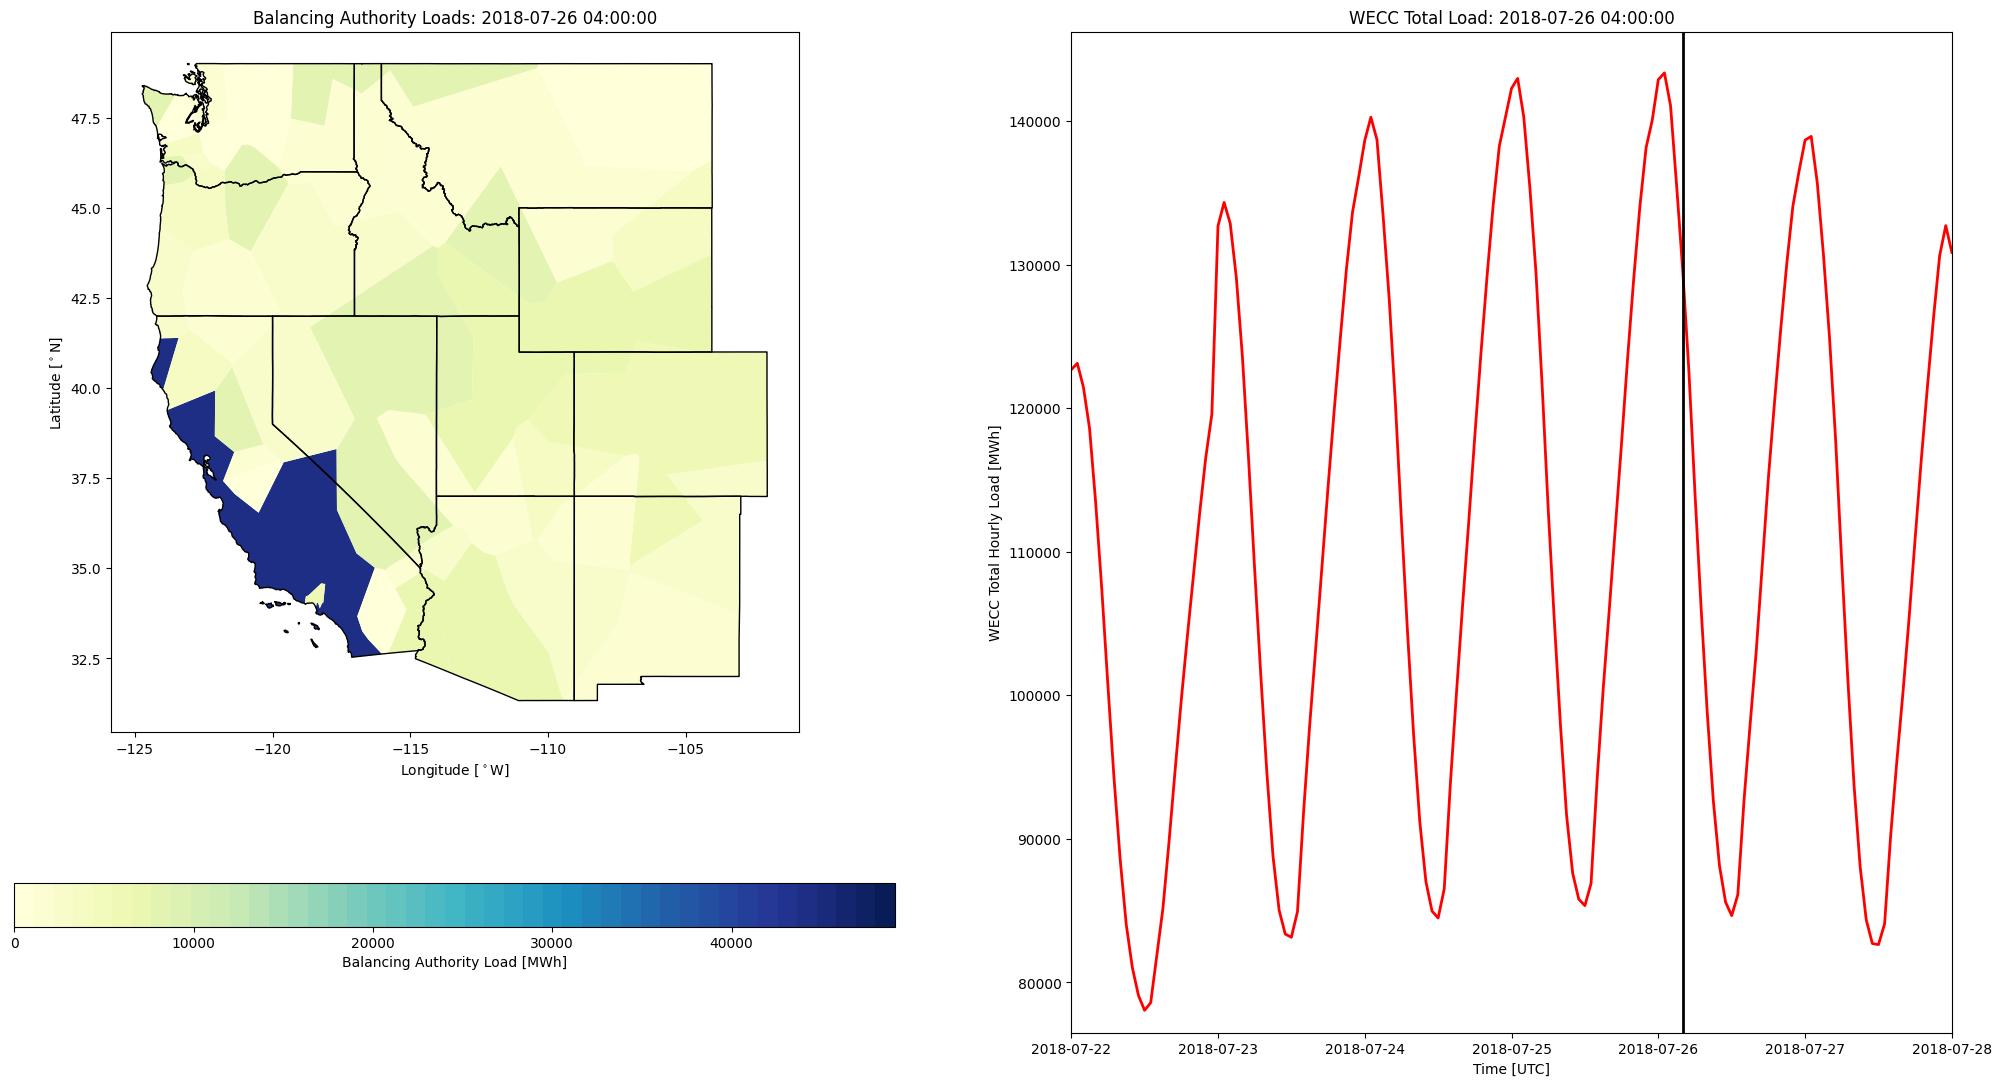

In [186]:
plot_ba_load_map(start_date = '2018-07-22 00:00:00',
                 end_date = '2018-07-28 00:00:00',
                 ba_load_dir = ba_load_dir, 
                 metadata_dir = metadata_dir,
                 image_output_dir = image_output_dir, 
                 image_resolution = 300, 
                 save_images = True)
